# Implemention of Linear Combination of Unitaries (LCU)

This code implements the basic Linear Combination of Unitaries (LCU) method.  For original references on LCU, please see [1]. This method utilizes functions previously created in *Select.ipynb*, *SP.ipynb*, and *Pauli_Decom.ipynb*. In summary, the LCU method implements the following transformation:

$$ \hat{H} = \sum_i \alpha_i \hat{U}_i = \begin{bmatrix}
        \hat{H} & * \\
        * & *
    \end{bmatrix} $$

The transformation involves $\hat{U}_i$, which represents the decomposition of the Hamiltonian into Pauli operators. This decomposition is implemented using *Pauli_Decom.ipynb*. Additionally, the coefficients associated with each $\hat{U}_i$ are defined by quantum state preparation.

<div align="center">
    <img src="images/LCU.png" width="600">
</div>

[1] https://arxiv.org/pdf/1202.5822.pdf

In [1]:
## Import all the libraries.
import numpy as np
from py_functions.SP import State_Preparation as sp
from py_functions.Select import Select as sel
from py_functions.Pauli_Decom import pauli_composition as pd
from qiskit import QuantumCircuit
import qiskit.quantum_info as qi

Define a matrix to decompose. It can be whatever matrix from $2\times2$ to $N \times N$ (carefull with the size).

In [9]:
#A = np.array([[1,1],[0,-1]])
A = np.array([[1,0,1,0],[0,-1,1,0],[0,1,-1,0],[0,0,0,1]])
print("Mi matrix:")
print(A)

Mi matrix:
[[ 1  0  1  0]
 [ 0 -1  1  0]
 [ 0  1 -1  0]
 [ 0  0  0  1]]


Decompose the previous matrix into Pauli operators and coefficients. ALl this information will be storage in a dictionary wich will be use to the functions.

In [10]:
pauli = pd.Decomposition(A) ## Dictionary
prob = np.abs(np.array(list(pauli.values())))
print(pauli)

{'II': 0.0, 'IX': 0.25, 'IY': 0.25j, 'IZ': 0.0, 'XI': 0.0, 'XX': 0.5, 'XY': 0j, 'XZ': 0.0, 'YI': 0j, 'YX': 0j, 'YY': (0.5+0j), 'YZ': 0j, 'ZI': 0.0, 'ZX': 0.25, 'ZY': 0.25j, 'ZZ': 1.0}


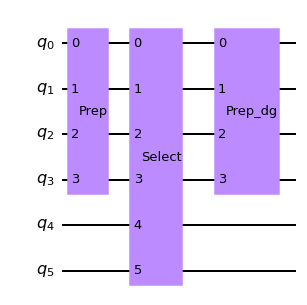

In [11]:
# Define the lens.
control_qubits = int(np.log2(len(prob)))
keys = list(pauli.keys())
pauli_qubits = len(keys[0])

### State preparation.
prep = sp.state_preparation(prob, 0)
qc_prep = QuantumCircuit(control_qubits, name="Prep")
qc_prep.append(prep, list(np.arange(0,control_qubits)))
### Inverse of State preparation.
prep_dagger = qc_prep.inverse()

### Select circuit.
select = sel.select_circuit(pauli)
qc_select = QuantumCircuit(control_qubits+pauli_qubits, name="Select")
qc_select.append(select, list(np.arange(0,control_qubits+pauli_qubits)))

### Put it all together.
qc_complete = QuantumCircuit(control_qubits+pauli_qubits)
qc_complete.append(qc_prep, list(np.arange(0,control_qubits)))
qc_complete.append(qc_select, list(np.arange(0,control_qubits+pauli_qubits)))
qc_complete.append(prep_dagger, list(np.arange(0,control_qubits)))
qc_complete.draw('mpl')

In [6]:
### This cell plot the upper-left corne sub-matrix that correspond to the same matrix as A with a normalization factor.

matrix_shape = A.shape[0]
op = qi.Operator(qc_complete).reverse_qargs()
array = op.data

def clean_matrix(matrix, threshold=0.01):
    cleaned_matrix = np.copy(matrix)
    for i in range(cleaned_matrix.shape[0]):
        for j in range(cleaned_matrix.shape[1]):
            element = cleaned_matrix[i, j]
            # Verifica si el valor absoluto del elemento es menor que el umbral
            if np.abs(element) < threshold:
                cleaned_matrix[i, j] = 0
            else:
                # Truncar las partes real e imaginaria a dos decimales
                real_part = np.round(element.real, 2)
                imag_part = np.round(element.imag, 2)
                cleaned_matrix[i, j] = real_part + 1j * imag_part
    return cleaned_matrix

cleaned_example_matrix = clean_matrix(array)

#print(cleaned_example_matrix) ## Uncomment this to see the entire matrix. 
print(cleaned_example_matrix[:matrix_shape,:matrix_shape])

[[ 0.33+0.j  0.  +0.j  0.33+0.j  0.  +0.j]
 [ 0.  +0.j -0.33+0.j  0.33+0.j  0.  +0.j]
 [ 0.  +0.j  0.33+0.j -0.33+0.j  0.  +0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j  0.33+0.j]]
